# Exercise session 5: Models of the visual system

During the lecture we studied how the responses of single neurons can inform us about the way the visual system works. In this exercise session, we will apply a similar approach to models of the visual system, to try to answer the question: <b>What is a good model of the brain's visual system?</b>

Throughout this notebook, you will find out at the beginning of each cell whether you need to adjust a parameter or just run the cell as it is.

Run the next cell to import the necessary code:

In [1]:
# Run without changing

!mkdir utils_ex5
!wget -P utils_ex5/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex5/vgg_utils.py
!wget -P utils_ex5/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex5/rao_ballard_trained.pkl

from utils_ex5.vgg_utils import *

# Import packages
import torch #machine learning package

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

# Table of contents:

* [Part I: Convolution neural networks as a model of the visual system](#cnns)
    * [1: Receptive Fields of CNNs](#rfs_cnns)
    * [2: Stimuli: Sinusoidal gratings](#gratings)
    * [3: Presenting stimuli to CNNs](#stimuli_cnns)
    * [4: Contrast saturation](#contrast_cnns)
    * [5: Cross-orientation inhibition](#inhibtion_cnns)
    * [6: Contrast saturation for optimal vs. sup-optimal orientation](#contrast_cnns_2)
    

* [Part II: Rao and Ballard model of predictive coding in V1](#rao_ballard)
    * [1: Contrast saturation](#contrast_rao)
    * [2: Cross-orientation inhibition](#inhibtion_rao)
    * [3: End-inhibiton](#end_inh_rao)


## Part I. Convolutional neural networks <a class="anchor" id="cnns"></a>

Convolutional neural networks (CNNs) are artificial neural network models that classify images by detecting what objects are inside the image. CNNs work by applying many "layers" of operations to the image to extract important information (below: feature learning) where "neurons" are the nodes in each layer. In a way, this is somewhat similar to the way the brain works by first computing simple properties of the world in primary visual cortex, and then building to complex representations in higher visual cortex. CNNs also work remarkably well as image classifiers, no other models come as close in accuracy to humans, so maybe they are a good model of the brain. In this exercise session we will try to find out.  

![](https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/images/cnn_architecture.png "Convolutional neural networks")

**Assignment 1** Assuming that CNNs are a good model of the brain, what sort of "neurons" would we find in the first layers of the CNN?

<details>
<Summary>Answer</Summary>

The first layers of the CNN we might find neurons similar to those of cells with center-surround cells like in the Thalamus (LGN). Alternatively, we might find "neurons" that respond to simple features like orientations and contrast like in V1.

</details>

Now, let's load a convolutional neural network (we are using a network called Alexnet, more info: [here](https://pytorch.org/hub/pytorch_vision_alexnet/))

In [2]:
# Run without changing

convolutional_neural_net = load_cnn_model()
layers = get_network_layers(convolutional_neural_net)

print('Below we display the architecture:')
print(convolutional_neural_net)

print('Our goal is to study how layers (0) to (12) transform the input image.')


Using cache found in /Users/ioanacalangiu/.cache/torch/hub/pytorch_vision_v0.10.0


Below we display the architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

## 1. Receptive Fields of the *convolutional layers*<a class="anchor" id="rfs_cnns"></a>

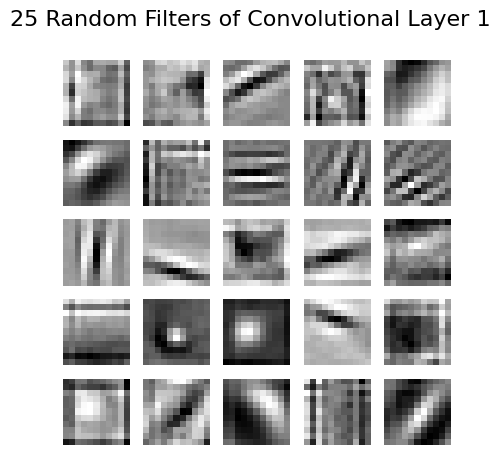

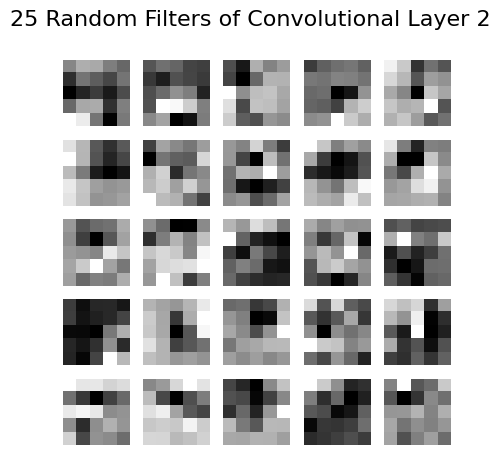

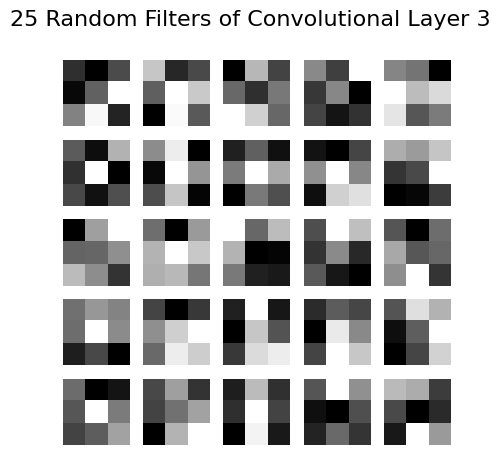

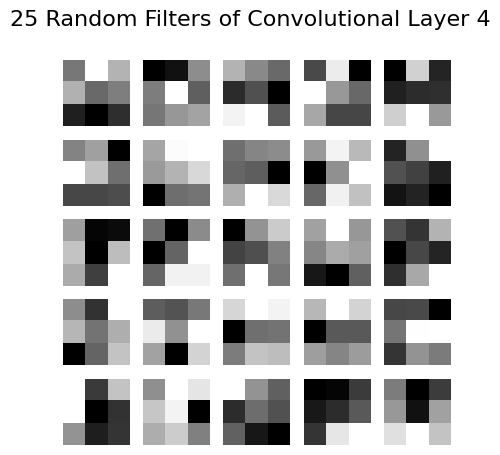

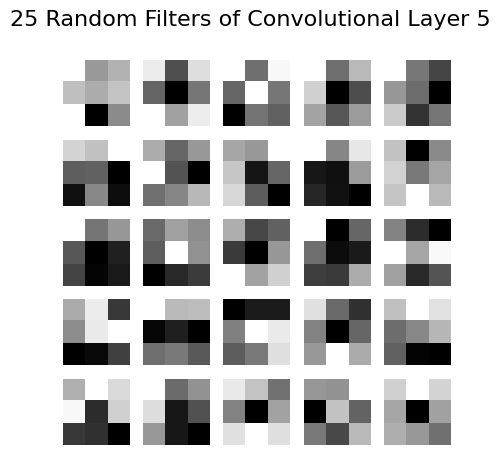

In [3]:
# Run without changing

plot_alexnet_rfs(convolutional_neural_net)

**Assignment 2** What happens with the receptive fields when you go into deeper layers?

<details>
<Summary>Answer</Summary>

When you go into deeper layers in a neural network, the receptive fields perform more abstract and high-level transformations on the input data.

</details>

## 2. Stimuli: sinusoidal gratings <a class="anchor" id="gratings"></a>

In this exercise session you will act like a neuroscientist investigating a real brain. You'll start simple: by investigating the network's response to very simple stimuli: the gratings seen in the lecture. Run the next piece of code to explore the parameters of the gratings.

In [4]:
# Run without changing

interact(interactive_grating, 
    frequency=FloatSlider(min=2, max=20, step=0.5, value=10, description="Frequency (Hz)",continuous_update=False),
    radius=IntSlider(min=1, max=100, step=10, value=12, description="Radius", continuous_update=False),
    contrast=FloatSlider(min=0.1, max=1., step=0.1, value=1, description="Contrast", continuous_update=False),
    orientation=IntSlider(min=0, max=180, step=12, value=90, description="Orientation", continuous_update=False),
    );

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='Frequency (Hz)', max=20.0,…

In the following sections we will perform a series of experiments on the CNN "neurons" to quantify their similarity to properties of real neurons in the visual system.

## 3. Presenting stimuli to CNNs <a class="anchor" id="stimuli_cnns"></a>

Just like the lecture, we will present different grating stimuli to the different "neurons" of the network. We will start with presenting gratings with different contrast levels

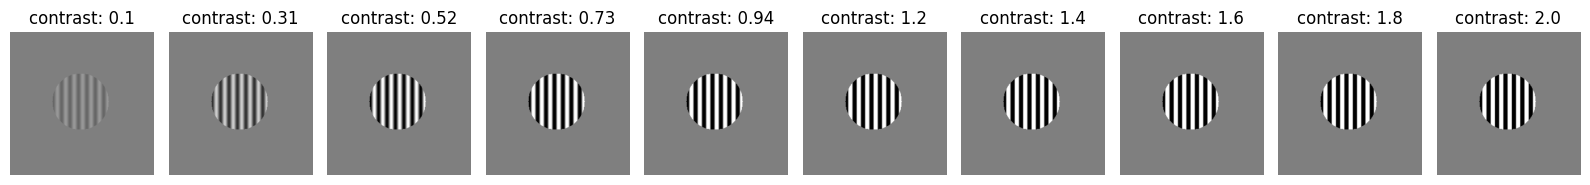

In [5]:
# Run without changing

# Set parameters
size = (256, 256)
center_x = 125
center_y = 125 
frequency = 15
orientation = 90
radius = 50


#generate different gratings with increasing contrasts
contrasts = np.linspace(0.1, 2, 10)
gratings = create_contrast_gratings(frequency, radius, contrasts, orientation)
plot_image_row(gratings, titles=[f'contrast: {c:.2}' for c in contrasts])

Next: we'll pass the gratings through the convolutional neural network.
 
We will investigate what types of computations are performed at the different layers. For this, we set a layer by setting the variable NUM_LAYERS and run a series of subsequent analyses to see how the output of the network looks like after NUM_LAYERS layers and how the output changes as we change the inputs.

We start with NUM_LAYERS = 1, which is the output of the (1): ReLU(inplace=True).

Run the following cell a few times, changing the parameter NUM_LAYERS, and look at 1) how the dimensionality of variable network_outputs changes and 2) how the network's output, i.e. neuron_response, changes.

The size of the input (gratings variable) is 256 x 256.
We are passing the input through the following layers: 
Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
The variable network_outputs has dimensionality 10 stimuli x 64 filters x 31 x 31 "neurons"


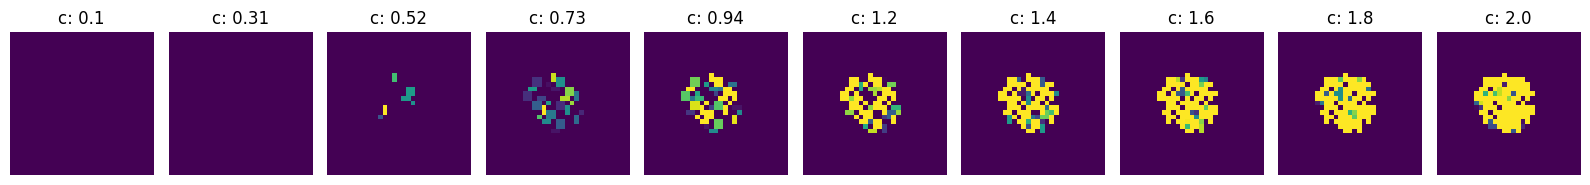

In [21]:
# Here you can change NUM_LAYERS variable to adjust the number of computations

print(f'The size of the input (gratings variable) is {gratings[0].shape[1]} x {gratings[0].shape[2]}.')

#This parameter determines how many layers of computation we are applying to the input image.
NUM_LAYERS = 2 # possible values: 1, 2, 3, 4, 5

network_layers = layers[0:NUM_LAYERS+1]
print('We are passing the input through the following layers: ')
print(network_layers)

#pass the gratings through the layers we selected
network_outputs = network_layers(gratings).detach()

print(f'The variable network_outputs has dimensionality {network_outputs.shape[0]} stimuli x {network_outputs.shape[1]} filters x {network_outputs.shape[2]} x {network_outputs.shape[3]} "neurons"')

#get the response from neuron 0
FILTER_NUMBER = 1
neuron_response = network_outputs[:, FILTER_NUMBER]

id_x, id_y = get_center(network_outputs.shape[2], network_outputs.shape[3])

#plot the responses of our neuron in the layer we selected
plot_image_row(neuron_response.unsqueeze(1), titles=[f'c: {c:.2}' for c in contrasts])

**Assignment 3** What happens to the resulted image when you apply more layers of computation? Run the previous cell and change the NUM_LAYERS. What happens before and after MaxPool2d?

<details>
<Summary>Answer</Summary>

The early layers "highlight" basic components of the image without altering the overall structure, while the deeper layers do not "see" the image in the way humans would; instead, they encode the features in a way that makes sense for classification or decision-making purposes. Before MaxPool2d the output is sparse, while after MaxPool2d the output is more dense. 

</details>

## 4. Experiment 1: Contrast saturation <a class="anchor" id="contrast_cnns"></a>

TODO: explain the experiment, add refs


Now we will plot the activity of each neuron as a function of different stimuli contrasts. The orientation of the stimuli is fixed across the different contrasts. Each line illustrates one neuron.

The variable network_outputs has dimensionality 10 stimuli x 192 filters x 31 x 31 "neurons"


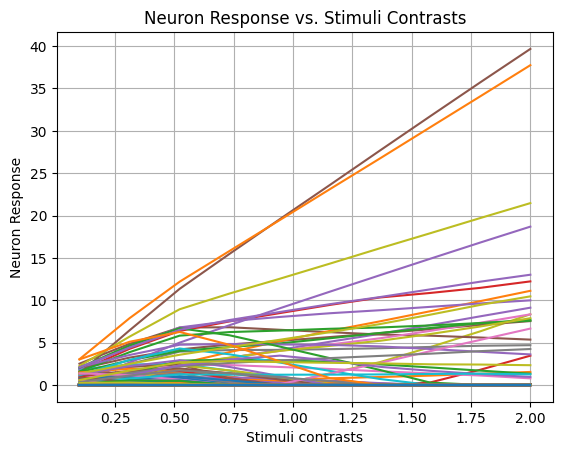

In [7]:
# Run without changing

print(f'The variable network_outputs has dimensionality {network_outputs.shape[0]} stimuli x {network_outputs.shape[1]} filters x {network_outputs.shape[2]} x {network_outputs.shape[3]} "neurons"')

_=plt.plot(contrasts, network_outputs[:, :, id_x, id_y].detach().numpy())

plt.xlabel('Stimuli contrasts')
plt.ylabel('Neuron Response')

# Optionally set a title
plt.title('Neuron Response vs. Stimuli Contrasts')

# Show the plot
plt.grid()
plt.show()


## 5. Experiment 2: Cross-orientation inhibition <a class="anchor" id="inhibtion_cnns"></a>

TODO: explain the experiment, add refs

### Find preferred orientation for each neuron

The first step is to identify for each neuron its preferred orientation. We will do this by computing each neuron's response to gratings of different orientations. We consider the orientation that elicits the highest response the neuron's preferred orientation

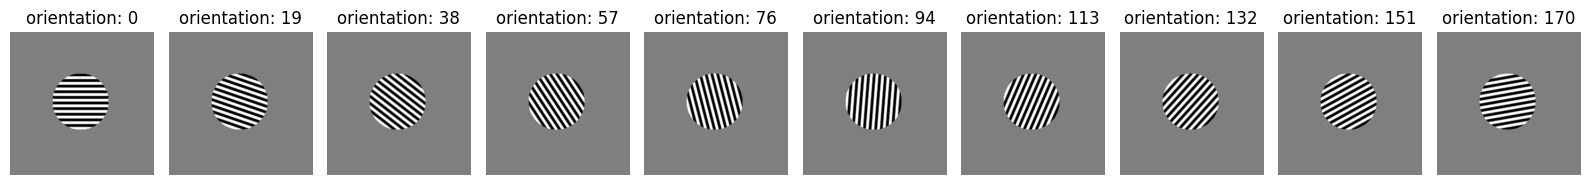

In [8]:
# Run without changing

# Set parameters
size = 256
center = (125, 125)

radius = 50
frequency = 10
contrast = 2

orientations = np.linspace(0, 170, 10)

gratings = create_orientation_gratings(frequency, radius, contrast, orientations, size, center)
plot_image_row(gratings, titles=[f'orientation: {o:.0f}' for o in orientations])

Now we will plot the activity of each neuron as a function of different stimuli orientations. The contrast is now fixed. Each line illustrates one neuron.

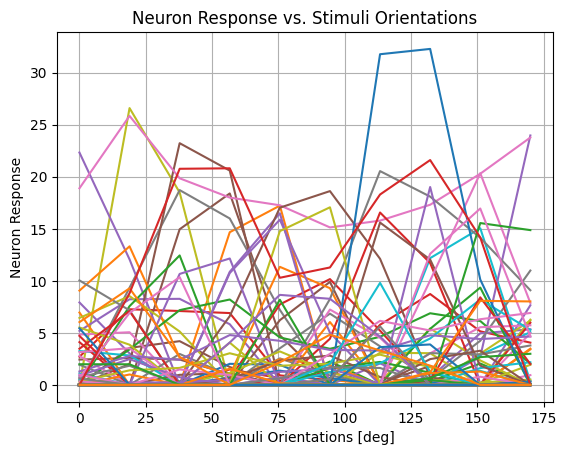

In [9]:
# Run without changing

network_layers = layers[0:NUM_LAYERS+1]
network_outputs = network_layers(gratings)

_=plt.plot(orientations, network_outputs[:, :, id_x, id_y].detach().numpy())

# Set the x-axis and y-axis labels
plt.xlabel('Stimuli Orientations [deg]')
plt.ylabel('Neuron Response')

# Optionally set a title
plt.title('Neuron Response vs. Stimuli Orientations')

# Show the plot
plt.grid()
plt.show()

**Assignment 4** How do we determine a neuron's preferred orientation?

<details>
<Summary>Answer</Summary>

We will determine each neuron's preferred orientation by looking which stimuli orientation elicited the highest response.

</details>



In [10]:
# Run without changing

print(f'The output of the network after passing an input image through {NUM_LAYERS} layers is: {network_outputs.shape[0]} stimuli x {network_outputs.shape[1]} filters x {network_outputs.shape[2]} x {network_outputs.shape[3]} neurons')

m = network_outputs[:, :, id_x, id_y].detach().numpy()

print(f'The tuning curve of each neuron is stored in variable m of dimensionality {m.shape[0]} stimuli x {m.shape[1]} filters')

# We take the maximum across rows, i.e. for each neuron we look which stimuli elicited the highest response
max_indices = np.argmax(m, axis=0) 
neuron_pref_orientation = orientations[max_indices]

print(f'Each neurons preffered orientation is stored in variable neuron_pref_orientation of dimensionality {neuron_pref_orientation.shape[0]}')


The output of the network after passing an input image through 4 layers is: 10 stimuli x 192 filters x 31 x 31 neurons
The tuning curve of each neuron is stored in variable m of dimensionality 10 stimuli x 192 filters
Each neurons preffered orientation is stored in variable neuron_pref_orientation of dimensionality 192


**Assignment 5** Inspecting the figure above: are all neurons behaving similarly?

<details>
<Summary>Answer</Summary>

Different neurons have different preferred orientations, i.e. their highest response is elicited by different stimuli. Moreover, some neurons are tuned to orientation (their activity changes as a function of the orientations), while some neurons are untuned (their activity is invariant to the orientation).

</details>



**Assignment 6** How could we select only the neurons that are tuned?


<details>
<Summary>Answer</Summary>

One possibility is to compute the variance across stimuli orientations. The higher the variance, the better the tuning of the neuron.

</details>



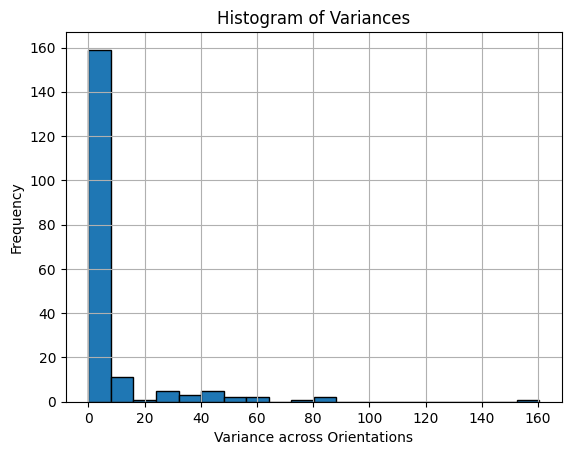

In [11]:
# Run without changing

variances = np.var(m, axis=0)

# Plot the histogram of the variances
plt.hist(variances, bins=20, edgecolor='black')
plt.title('Histogram of Variances')
plt.xlabel('Variance across Orientations')
plt.ylabel('Frequency')
plt.grid()
plt.show()

### Super-imposing two gratings: grating of preferred orientation and grating of orthogonal orientation

For each neuron, we compute its response to its optimal Gabor superimposed with an orthogonal Gabor of varying contrasts.

In [12]:
# Here you can change the variance_threshold variable to adjust how many units to keep. Choose a value such that there is at least one neuron with the variance higher. The distribution changes when you change NUM_LAYERS.

variance_threshold = 20
valid_neurons = variances > variance_threshold # we select an *arbitrary* threshold to focus only on the most tuned units
valid_neuron_indices = np.nonzero(valid_neurons)[0]

print('A list of tuned units: ', valid_neuron_indices)


A list of tuned units:  [  1   8  15  19  27  34  35  61  64  65  72  73  84  97 104 115 116 138
 140 152 166 183]


Prefered orientation of neuron 0 is 76 and orth orientation is 166.
Orthogonal orientation 166


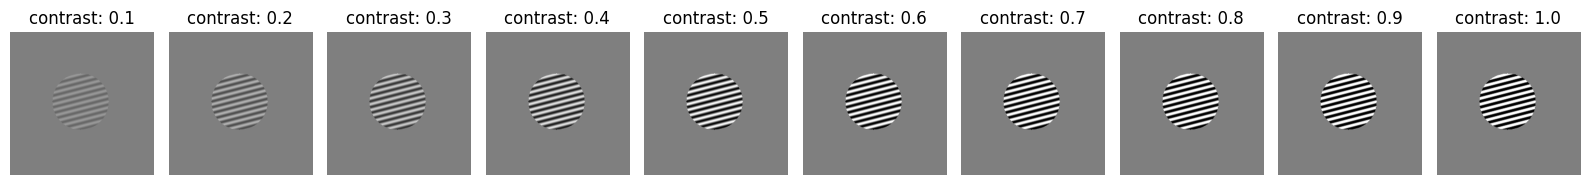

Prefered and orthogonal orientation super-imposed


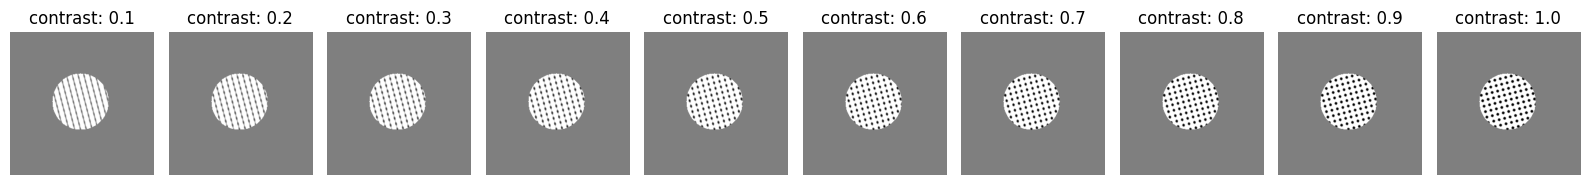

In [13]:
# Run without changing

FILTER_NUMBER = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[FILTER_NUMBER]])

print(f'Prefered orientation of neuron {FILTER_NUMBER} is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}.')

# Set parameters
size = 256
center = (125, 125)
radius = 50
frequency = 10
contrast = 2

orientations = np.linspace(0, 170, 10)
contrast_pref = np.linspace(1, 1, 1)
contrasts_orth = np.linspace(0.1, 1, 10)

print(f'Orthogonal orientation {orth_orientation:.0f}')
gratings_orthogonal = create_contrast_gratings(frequency, radius, contrasts_orth, orth_orientation)
plot_image_row(gratings_orthogonal, titles=[f'contrast: {c:.2}' for c in contrasts_orth])

print('Prefered and orthogonal orientation super-imposed')
gratings_superimposed = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size, center)
plot_image_row(gratings_superimposed, titles=[f'contrast: {c:.2}' for c in contrasts_orth])

In [14]:
# Run without changing

# We pass the two types of stimuli (orthogonal and super-imposed through the network)
network_layers = layers[0:NUM_LAYERS+1]
network_outputs_superimposed = network_layers(gratings_superimposed)
network_outputs_orthogonal = network_layers(gratings_orthogonal)

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.

### Response of a neuron to super-imposed gratings (one contrast value for preferred orientation grating)

The response of a neuron when we super-imposed a grating of orthogonal direction and varying contrasts to a grating of its preferred orientation and high contrast (2)

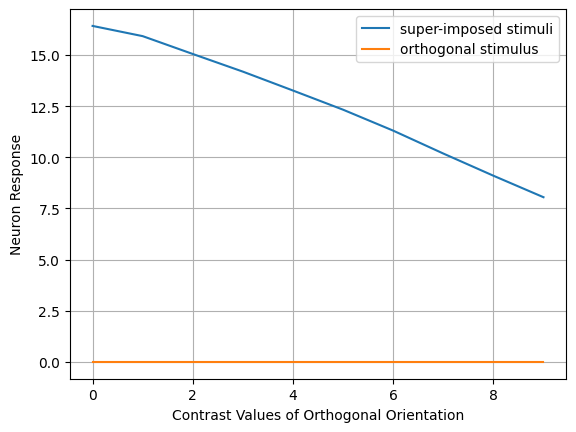

In [15]:
# Run without changing

_=plt.plot(network_outputs_superimposed[:, valid_neuron_indices[FILTER_NUMBER],id_x,id_y].detach().numpy(), label = 'super-imposed stimuli')
_=plt.plot(network_outputs_orthogonal[:, valid_neuron_indices[FILTER_NUMBER],id_x,id_y].detach().numpy(), label = 'orthogonal stimulus')


plt.xlabel('Contrast Values of Orthogonal Orientation')
plt.ylabel('Neuron Response')
plt.legend()
# Show the plot
plt.grid()
plt.show()

**Assignment 7** How does the neuron respond to the orthogonal grating and how does the response to a preferred orientation change when we add an orthogonal grating? How does this compare to the response of a V1 neuron?


<details>
<Summary>Answer</Summary>

TODO: add referens to V1 neuron.

</details>

### Response of a neuron to super-imposed gratings (all contrast values for preferred orientation grating)

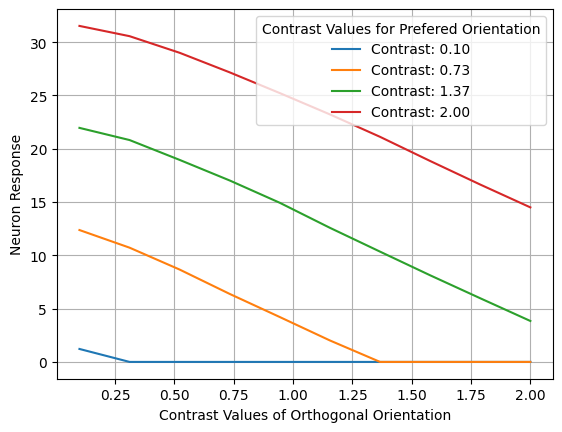

In [16]:
# Run without changing

contrasts_orth = np.linspace(0.1, 2, 10)
contrasts_pref_sweep = np.linspace(0.1, 2, 4)

for c in contrasts_pref_sweep:
    contrast_pref = np.linspace(c, c, 1)
    gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size, center)

    network_layers = layers[0:NUM_LAYERS+1]
    network_outputs = network_layers(gratings)
    _=plt.plot(contrasts_orth, network_outputs[:, valid_neuron_indices[FILTER_NUMBER],id_x,id_y].detach().numpy(), label=f'Contrast: {c:.2f}')


plt.xlabel('Contrast Values of Orthogonal Orientation')
plt.ylabel('Neuron Response')

# Show the legend
plt.legend(title='Contrast Values for Prefered Orientation')
# Show the plot
plt.grid()
plt.show()

**Assignment 8** Similarly to Assignment 7, how does the response of the neuron to an optimal orientation change when we add an orthogonal grating? TODO (red)


<details>
<Summary>Answer</Summary>

TODO: add referens to V1 neuron.

</details>

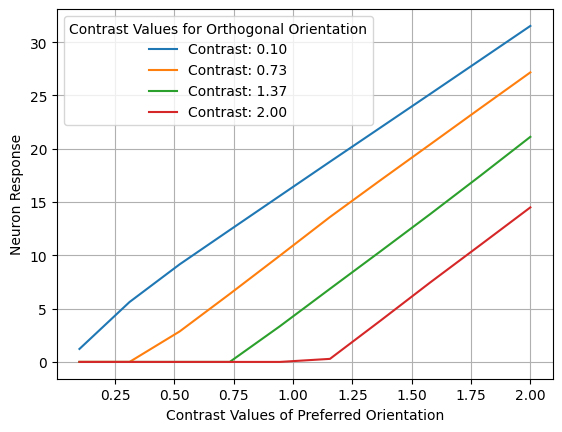

In [17]:
# Run without changing

contrasts_orth_sweep = np.linspace(0.1, 2, 4)
contrasts_pref = np.linspace(0.1, 2, 10)

for c in contrasts_orth_sweep:
    contrast_orth = np.linspace(c, c, 1)
    gratings = create_superimposed_gratings(frequency, radius, contrast_orth, contrasts_pref, orth_orientation, pref_orientation, size, center)

    network_layers = layers[0:NUM_LAYERS+1]
    network_outputs = network_layers(gratings)
    _=plt.plot(contrasts_pref, network_outputs[:, valid_neuron_indices[FILTER_NUMBER],id_x,id_y].detach().numpy(), label=f'Contrast: {c:.2f}')


plt.xlabel('Contrast Values of Preferred Orientation')
plt.ylabel('Neuron Response')

# Show the legend
plt.legend(title='Contrast Values for Orthogonal Orientation')
# Show the plot
plt.grid()
plt.show()

## 6. Contrast saturation for optimal vs. sup-optimal orientation <a class="anchor" id="contrast_cnns_2"></a>

In [ ]:
# Run without changing

FILTER_NUMBER = 1
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[FILTER_NUMBER]])

suboptimal_orientation = pref_orientation - 15

# Set parameters
size = (256, 256)
center_x = 125
center_y = 125 
frequency = 7.5
radius = 50

contrasts = np.linspace(0.1, 3, 10)


#generate different gratings with increasing contrasts
gratings = create_contrast_gratings(frequency, radius, contrasts, pref_orientation)
#select the layers of the network we want to pass the gratings through
network_layers = layers[0:NUM_LAYERS+1]
#pass the gratings through the layers we selected
#this matrix has the following shape: contrasts x number of filters x neuron response (2d)
network_outputs_optimal = network_layers(gratings).detach()


response_optimal = network_outputs_optimal[:, valid_neuron_indices[FILTER_NUMBER], id_x, id_y]
gratings = create_contrast_gratings(frequency, radius, contrasts, suboptimal_orientation)
#select the layers of the network we want to pass the gratings through
network_layers = layers[0:NUM_LAYERS+1]
#pass the gratings through the layers we selected
#this matrix has the following shape: contrasts x filters x neuron response (2d)
network_outputs_suboptimal = network_layers(gratings).detach()
response_suboptimal = network_outputs_suboptimal[:, valid_neuron_indices[FILTER_NUMBER],id_x,id_y]


_=plt.plot(contrasts, response_suboptimal.detach().numpy())
_=plt.plot(contrasts, response_optimal.detach().numpy())

# Set the x-axis and y-axis labels
plt.xlabel('Contrasts')
plt.ylabel('Neuron Response')

# Optionally set a title
plt.title('Neuron Response vs. Contrasts')

# Show the plot
plt.grid()
plt.show()


## 7. Tuning to stimulus-size <a class="anchor" id="size_cnns_2"></a>

**Assignment 9** How does the response of a neuron change with stimulus size?


<details>
<Summary>Answer</Summary>

For some neurons the response first increases with stimulus size and then it decreases. This is a non-classical receptive field effect.
</details>

In [ ]:
# Run without changing

# Set parameters
size = 256
center = (125, 125)

frequency = 10
contrast = 2
orientation = 0

radii = np.linspace(10, 50, 10)

gratings = create_radius_gratings(frequency, radii, contrast, orientation, size, center)
plot_image_row(gratings, titles=[f'orientation: {r:.0f}' for r in radii])

In [ ]:
# Run without changing

network_layers = layers[0:NUM_LAYERS+1]
network_outputs = network_layers(gratings)

_=plt.plot(orientations, network_outputs[:, :, id_x, id_y].detach().numpy())

# Set the x-axis and y-axis labels
plt.xlabel('Stimulus Size (radius)')
plt.ylabel('Neuron Response')

# Optionally set a title
plt.title('Neuron Response vs. Stimulus Size')

# Show the plot
plt.grid()
plt.show()

Now that we have run all these experiments on one layer (NUM_LAYERS = 1), go back to where this variable is set and see how the results change as you go deeper into the network.

## Part II. Rao and Ballard model of predictive coding in V1 <a class="anchor" id="rao_ballard"></a>

[Rajesh P. N. Rao & Dana H. Ballard Nature 1999 - Predictive coding in the visual cortex: a functional interpretation of some extra-classical receptive-field effects.](https://www.nature.com/articles/nn0199_79)


In [ ]:
# Run without changing

#load the trained rao and ballard model
model = load_rao_ballard()

In [ ]:
# Run without changing

# Set parameters
frequency = 3
orientation = 90
radius = 6


#generate different gratings with increasing contrasts
contrasts = np.linspace(0.1, 20, 10)
gratings = create_contrast_gratings(frequency, radius, contrasts, orientation, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'c: {c:.2f}' for c in contrasts])

In [86]:
# Run without changing

model.initialize_states(gratings[0].reshape(3, 256).numpy())

layer_1_activities_per_contrast = np.zeros((len(gratings), 32))
layer_2_activities_per_contrast = np.zeros((len(gratings), 128))

for i, g in enumerate(gratings):
    #the model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_contrast[i] = abs(l1).mean(0)
    layer_2_activities_per_contrast[i] = abs(l2)

## 1. Contrast saturation <a class="anchor" id="contrast_rao"></a>


**Assignment 10** Do neurons in layer 1 and layer 2 show contrast saturation?


<details>
<Summary>Answer</Summary>

TODO: add referens to V1 neuron.

</details>

In [ ]:
# Run without changing

_=plt.plot(contrasts, layer_1_activities_per_contrast)
plt.xlabel('contrast')
plt.ylabel('average activity')


## 2. Cross-orientation inhibition <a class="anchor" id="inhibtion_rao"></a>


In [ ]:
# Run without changing

# Set parameters
frequency = 3
radius = 6
contrast = 2

orientations = np.linspace(0, 170, 10)

gratings = create_orientation_gratings(frequency, radius, contrast, orientations, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'orientation: {o:.0f}' for o in orientations])

In [90]:
# Run without changing

model.initialize_states(gratings[0].reshape(3, 256).numpy())

layer_1_activities_per_orientation = np.zeros((len(gratings), 32))
layer_2_activities_per_orientation = np.zeros((len(gratings), 128))

for i, g in enumerate(gratings):
    #the model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_orientation[i] = abs(l1).mean(0)
    layer_2_activities_per_orientation[i] = abs(l2)

In [ ]:
# Run without changing

_=plt.plot(orientations, layer_1_activities_per_orientation)
plt.xlabel('orientations')
plt.ylabel('average activity')

In [ ]:
# Run without changing

m = layer_1_activities_per_orientation
print(m.shape) # Number of Stimuli Orientations x Number of Neurons
max_indices = np.argmax(m, axis=0) # we take the maximum across rows, i.e. for each neuron we look which stimuli elicited the highest response
neuron_pref_orientation = orientations[max_indices]
print(neuron_pref_orientation.shape)

In [ ]:
# Run without changing

variances = np.var(m, axis=0)

# Plot the histogram of the variances
plt.hist(variances, bins=20, edgecolor='black')
plt.title('Histogram of Variances')
plt.xlabel('Variance across Orientations')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [ ]:
# Here you can change the variance_threshold variable to adjust how many units to keep. Choose a value such that there is at least one neuron with the variance higher. The distribution changes when you change NUM_LAYERS.

variance_threshold = 0.4*1e-5
valid_neurons = variances > variance_threshold # we select an *arbitrary* threshold to focus only on the most tuned units

valid_neuron_indices = np.nonzero(valid_neurons)[0]

print('A list of tuned units: ', valid_neuron_indices)

In [ ]:
# Run without changing

neuron_index = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron_index]])
print(f'Prefered orientation is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}')

frequency = 3
radius = 6
c = 2


contrasts_orth = np.linspace(0.1, 2, 10)
contrast_pref = np.linspace(c, c, 1)
gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'contrast: {ctr:.2f}' for ctr in contrasts_orth])

In [ ]:
# Run without changing

neuron_index = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron_index]])

print(f'Prefered orientation is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}')

contrasts_orth = np.linspace(0.1, 2, 10)
contrasts_pref_sweep = np.linspace(2, 2, 4)

for c in contrasts_pref_sweep:
    contrast_pref = np.linspace(c, c, 1)
    gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size=16, center=(8, 8))

    model.initialize_states(gratings[0].reshape(3, 256).numpy())


    layer_1_activities_per_orientation = np.zeros((len(gratings), 32))
    layer_2_activities_per_orientation = np.zeros((len(gratings), 128))

    for i, g in enumerate(gratings):
        #the model is expecting a flattened representation of the image
        er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
        layer_1_activities_per_orientation[i] = abs(l1).mean(0)
        layer_2_activities_per_orientation[i] = abs(l2)

    m = layer_1_activities_per_orientation[:, [valid_neuron_indices[neuron_index]]]

    _=plt.plot(contrasts_orth, m, label=f'Contrast: {c:.2f}')

plt.xlabel('Contrast Values of Orthogonal Orientation')
plt.ylabel('Neuron Response')

plt.grid()
plt.show()

## 3. End-inhibiton <a class="anchor" id="end_inh_rao"></a>


In [ ]:
# Run without changing

# Set parameters
size = 16
center = (8,8)
contrast = 2
width = 1

lengths = np.linspace(1, 16, 10)

bars = create_bar_lengths(size, contrast, center, lengths, width)
plot_image_row(bars, titles=[f'lengths: {l:.0f}' for l in lengths])

In [99]:
# Run without changing

model.initialize_states(bars[0].reshape(3, 256).numpy())

layer_1_activities_per_contrast = np.zeros((len(bars), 32))
layer_2_activities_per_contrast = np.zeros((len(bars), 128))

for i, g in enumerate(bars):
    #the model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_contrast[i] = abs(l1).mean(0)
    layer_2_activities_per_contrast[i] = abs(l2)

In [ ]:
# Run without changing

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for layer 1 neurons
ax1.plot(lengths, layer_1_activities_per_contrast)
ax1.set_xlabel('Bar Lengths')
ax1.set_ylabel('Average Activity')
ax1.set_title('Mean response for Layer 1 neurons')

# Plot for layer 2 neurons
ax2.plot(lengths, layer_2_activities_per_contrast)
ax2.set_xlabel('Bar Lengths')
ax2.set_ylabel('Average Activity')
ax2.set_title('Mean response for Layer 2 neurons')

# Display the plots side by side
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()
